# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ealaxi/paysim1 . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import numpy as np

In [4]:
imbalanced = pd.read_csv('../PS_log.csv',nrows=100000)

In [5]:
imbalanced.shape

(100000, 11)

In [6]:
imbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [9]:
list(imbalanced.columns)

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [7]:
imbalanced.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
imbalanced.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
41423,9,CASH_OUT,390567.04,C1784190590,241884.99,0.00,C147916733,2218441.26,2098523.32,0,0
89876,10,CASH_OUT,20009.05,C1313570284,0.00,0.00,C1010788641,161538.64,181547.69,0,0
20827,8,PAYMENT,26042.17,C62795755,33053.37,7011.20,M993121487,0.00,0.00,0,0
7494,7,PAYMENT,2570.96,C1131634336,198381.00,195810.04,M1398450119,0.00,0.00,0,0
62617,9,CASH_IN,61841.20,C2132418631,1405568.59,1467409.79,C1789550256,7486134.54,7629915.92,0,0
16216,8,PAYMENT,3320.69,C1383792319,202731.00,199410.31,M1674174327,0.00,0.00,0,0
21957,8,CASH_OUT,275557.00,C2116973935,10025.00,0.00,C290945720,0.00,455892.27,0,0
81783,10,PAYMENT,8684.41,C344037519,501.00,0.00,M1166636616,0.00,0.00,0,0
92447,10,CASH_IN,85287.33,C1703821392,743205.17,828492.50,C1002973288,966853.57,918942.47,0,0
55352,9,PAYMENT,22727.50,C1171344231,0.00,0.00,M1628222693,0.00,0.00,0,0


In [13]:
imbalanced.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,8.499640,1.736022e+05,8.777575e+05,8.940619e+05,8.805048e+05,1.184041e+06,0.001160,0.0
std,1.825545,3.443003e+05,2.673284e+06,2.711318e+06,2.402267e+06,2.802350e+06,0.034039,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,9.963562e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.274552e+04,2.006150e+04,0.000000e+00,2.083943e+04,4.990918e+04,0.000000,0.0
75%,10.000000,2.117631e+05,1.901920e+05,2.148132e+05,5.882724e+05,1.058186e+06,0.000000,0.0
max,10.000000,1.000000e+07,3.379739e+07,3.400874e+07,3.400874e+07,3.894623e+07,1.000000,0.0


### What is the distribution of the outcome? 

In [11]:
display(imbalanced['isFraud'].value_counts())

#Very low % is detected as fraud

0    99884
1      116
Name: isFraud, dtype: int64

<AxesSubplot:>

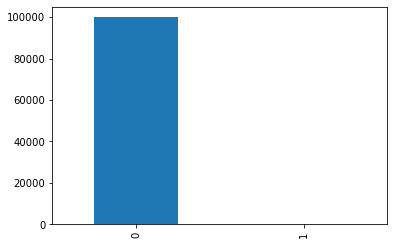

In [23]:
import matplotlib.pyplot as plt

pd.value_counts(imbalanced['isFraud']).plot(kind='bar')

In [24]:
# Your response here
display(imbalanced['isFlaggedFraud'].value_counts())


0    100000
Name: isFlaggedFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [1]:
# Your code here
#not sure how to code this one, it would be step by step meaning

In [25]:
imbalanced['step'].value_counts()

9     37628
10    27274
8     21097
7      6837
1      2708
6      1660
2      1014
5       665
4       565
3       552
Name: step, dtype: int64

In [26]:
imbalanced['type'].value_counts()


PAYMENT     39512
CASH_OUT    30718
CASH_IN     20185
TRANSFER     8597
DEBIT         988
Name: type, dtype: int64

In [28]:
df_imbdum = pd.get_dummies(imbalanced['type'],drop_first=True)

df_imbdum

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
99995,0,0,1,0
99996,0,0,1,0
99997,0,0,0,0
99998,1,0,0,0


In [31]:
df_join = pd.merge(left=imbalanced, right=df_imbdum,left_index=True,right_index=True)
df_join

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,0,0,1,0
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,0,0,1,0
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,0,0,0,0
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,1,0,0,0


In [32]:
df_join.drop(columns=['type','nameOrig','nameDest','isFlaggedFraud'], inplace=True, axis=1)


In [33]:
df_join.head(5)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


### Run a logisitc regression classifier and evaluate its accuracy.

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

model = LogisticRegression()

In [46]:
X = df_join.loc[:, df_join.columns != 'isFraud']
y = df_join['isFraud']

In [50]:
# Your code here
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [59]:
model = model.fit(X_train, y_train)

In [65]:
display(model.score(X_test,y_test))
display(model.score(X_train, y_train))

0.999

0.9989

### Now pick a model of your choice and evaluate its accuracy.

In [66]:
#Knn with 3 neighboors
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3)

In [70]:
 model2 = model2.fit(X_train, y_train)
model2.predict(X_test)
np.array(y_test)
accuracy_score(model2.predict(X_test),np.array(y_test))


0.99875

In [72]:
pred = model2.predict(X_test)

precision_score(y_test,pred)

0.2857142857142857

### Which model worked better and how do you know?

In [2]:
# Your response here


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.